#### Where I am...
Scored 1.018 with time-based features
- first 12 months excluded (to account for an obvious downward trend overtime)
- one-hot encoded month (to capture spikes in Dec, Mar, etc.)
- lag 1-5, 12 of sales by
    - shop-item
    - shop
    - item 
    - category

#### Ideas
1. More to explore in the time features
    - trend (e.g. sales go down from last month? how long is the trend?)
2. Other features
    - category/product names?
    - \# shops sold in?
    - price change?
3. Parameter tuning
4. Ensemble

In [1]:
import os
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# preprocessing
from sklearn.preprocessing import OneHotEncoder

from sklearn import model_selection
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from itertools import product # to expand month-shop-item combo

import pickle

import gc
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

In [2]:
def rmse_clip(y_true, y_pred):
    y_pred = y_pred.clip(0,20)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    return(rmse)

### Read in Data

In [3]:
%%time
monthly_sales_all = pd.read_hdf(r'../data2/monthly_sales_all_shop_item_w_lag.h5','monthly_sales_all')

Wall time: 7.35 s


In [5]:
monthly_sales_all = monthly_sales_all[monthly_sales_all.date_block_num>=12]

In [6]:
monthly_sales_all['shop_item_trd_1'] = ((monthly_sales_all['shop_item_cnt'] - monthly_sales_all['shop_item_cnt_lag_1'])>=0).astype(np.int32)
monthly_sales_all['shop_trd_1'] = ((monthly_sales_all['shop_cnt'] - monthly_sales_all['shop_cnt_lag_1'])>=0).astype(np.int32)
monthly_sales_all['item_trd_1'] = ((monthly_sales_all['item_cnt'] - monthly_sales_all['item_cnt_lag_1'])>=0).astype(np.int32)
monthly_sales_all['cat_trd_1']  = ((monthly_sales_all['cat_cnt']  - monthly_sales_all['cat_cnt_lag_1'])>=0).astype(np.int32)

In [7]:
# monthly_sales_all['shop_item_trd_2'] = ((monthly_sales_all['shop_item_cnt_lag_1'] - monthly_sales_all['shop_item_cnt_lag_2'])>=0).astype(np.int32)
# monthly_sales_all['shop_trd_2'] = ((monthly_sales_all['shop_cnt_lag_1'] - monthly_sales_all['shop_cnt_lag_2'])>=0).astype(np.int32)
# monthly_sales_all['item_trd_2'] = ((monthly_sales_all['item_cnt_lag_1'] - monthly_sales_all['item_cnt_lag_2'])>=0).astype(np.int32)
# monthly_sales_all['cat_trd_2']  = ((monthly_sales_all['cat_cnt_lag_1']  - monthly_sales_all['cat_cnt_lag_2'])>=0).astype(np.int32)

In [8]:
# monthly_sales_all['shop_item_trd_3'] = ((monthly_sales_all['shop_item_cnt_lag_2'] - monthly_sales_all['shop_item_cnt_lag_3'])>=0).astype(np.int32)
# monthly_sales_all['shop_trd_3'] = ((monthly_sales_all['shop_cnt_lag_2'] - monthly_sales_all['shop_cnt_lag_3'])>=0).astype(np.int32)
# monthly_sales_all['item_trd_3'] = ((monthly_sales_all['item_cnt_lag_2'] - monthly_sales_all['item_cnt_lag_3'])>=0).astype(np.int32)
# monthly_sales_all['cat_trd_3']  = ((monthly_sales_all['cat_cnt_lag_2']  - monthly_sales_all['cat_cnt_lag_3'])>=0).astype(np.int32)

- <strong>One-hot encode month</strong>

In [9]:
enc = OneHotEncoder()

In [10]:
m_onehot = enc.fit_transform(pd.Series(list(range(1,13))).reshape(-1,1)).toarray()
m_onehot.shape
# 12 levels -> 12 features, need to drop 1 to avoid multicolinearity (since we are first going to fit a linear model)

# reshape(-1,1) -1 means unknown dimension which we just let numpy to figure out
# since OneHotEncoder() takes 2-D array, we need to make our 1D series into a 2-D matrix format
# we know there is one column, and let numpy to figure out how many rows there should be
# <=> reshape.(rows_in_your_data,1)

(12, 12)

In [11]:
m_onehot_df = pd.DataFrame(np.hstack((np.array(range(1,13)).reshape(12,1),m_onehot[:,1:])), columns=['month']+['m'+str(i) for i in range(2,13)], dtype='int32')
m_onehot_df

,month,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,1,0,0,0,0,0,0,0,0,0,0,0
1,2,1,0,0,0,0,0,0,0,0,0,0
2,3,0,1,0,0,0,0,0,0,0,0,0
3,4,0,0,1,0,0,0,0,0,0,0,0
4,5,0,0,0,1,0,0,0,0,0,0,0
5,6,0,0,0,0,1,0,0,0,0,0,0
6,7,0,0,0,0,0,1,0,0,0,0,0
7,8,0,0,0,0,0,0,1,0,0,0,0
8,9,0,0,0,0,0,0,0,1,0,0,0
9,10,0,0,0,0,0,0,0,0,1,0,0


In [12]:
monthly_sales_all = pd.merge(monthly_sales_all,m_onehot_df,how='left',on='month').drop(labels=['month'],axis=1)
monthly_sales_all[:3]

,cat_cnt,date_block_num,item_category_id,item_cnt,item_id,shop_cnt,shop_id,shop_item_cnt,cat_cnt_lag_1,item_cnt_lag_1,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,7545.0,12,37,0.0,22154,1500.0,59,0.0,9989.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,6044.0,13,37,0.0,22154,1428.0,59,0.0,7545.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,6334.0,14,37,0.0,22154,1475.0,59,0.0,6044.0,0.0,...,1,0,0,0,0,0,0,0,0,0


In [13]:
%%time
monthly_sales_all.to_hdf(r'../data2/monthly_sales_ex_fst_12m_w_lag_1hot_tr.h5','monthly_sales_all')

Wall time: 49.6 s


#### Predict w lag v RF w lag

In [16]:
hold_out_month = 33
val_month = 32

#### Benchmark - on val and hold-out

In [12]:
feats = ['shop_item_cnt_lag_1']

hold_out_df = monthly_sales_all.loc[monthly_sales_all.date_block_num == hold_out_month,
                            ['shop_id','item_id','shop_item_cnt']+feats]
val = monthly_sales_all.loc[monthly_sales_all.date_block_num == val_month,
                            ['shop_id','item_id','shop_item_cnt']+feats]

print('Hold out BC (month 33):')
print(rmse_clip(y_true = hold_out_df.loc[hold_out_df.shop_item_cnt>0,'shop_item_cnt'],y_pred = hold_out_df.loc[hold_out_df.shop_item_cnt>0,'shop_item_cnt_lag_1']))

print('Val BC (month 32)')
print(rmse_clip(y_true = val.loc[val.shop_item_cnt>0,'shop_item_cnt'],y_pred = val.loc[val.shop_item_cnt>0,'shop_item_cnt_lag_1']))

Hold out BC (month 33):
14.38222156410965
Val BC (month 32)
18.07412546239703


#### Model

In [13]:
monthly_sales_all.columns

Index(['cat_cnt', 'date_block_num', 'item_category_id', 'item_cnt', 'item_id',
       'shop_cnt', 'shop_id', 'shop_item_cnt', 'cat_cnt_lag_1',
       'item_cnt_lag_1', 'shop_cnt_lag_1', 'shop_item_cnt_lag_1',
       'cat_cnt_lag_2', 'item_cnt_lag_2', 'shop_cnt_lag_2',
       'shop_item_cnt_lag_2', 'cat_cnt_lag_3', 'item_cnt_lag_3',
       'shop_cnt_lag_3', 'shop_item_cnt_lag_3', 'cat_cnt_lag_4',
       'item_cnt_lag_4', 'shop_cnt_lag_4', 'shop_item_cnt_lag_4',
       'cat_cnt_lag_5', 'item_cnt_lag_5', 'shop_cnt_lag_5',
       'shop_item_cnt_lag_5', 'cat_cnt_lag_12', 'item_cnt_lag_12',
       'shop_cnt_lag_12', 'shop_item_cnt_lag_12', 'shop_item_trd_1',
       'shop_trd_1', 'item_trd_1', 'cat_trd_1', 'm2', 'm3', 'm4', 'm5', 'm6',
       'm7', 'm8', 'm9', 'm10', 'm11', 'm12'],
      dtype='object')

In [40]:
feats = ['shop_item_cnt_lag_1',  'item_cnt_lag_1',  'shop_cnt_lag_1', 'cat_cnt_lag_1',
         'shop_item_cnt_lag_2',  'item_cnt_lag_2',  'shop_cnt_lag_2', #'cat_cnt_lag_2',
         'shop_item_cnt_lag_3',  'item_cnt_lag_3',  'shop_cnt_lag_3', #'cat_cnt_lag_3',
         'shop_item_cnt_lag_4',  'item_cnt_lag_4',  'shop_cnt_lag_4', #'cat_cnt_lag_4',
         'shop_item_cnt_lag_5',  'item_cnt_lag_5',  'shop_cnt_lag_5', #'cat_cnt_lag_5',
         'shop_item_cnt_lag_12', 'item_cnt_lag_12', 'shop_cnt_lag_12',#'cat_cnt_lag_12',
         'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
         'shop_item_trd_1', 'shop_trd_1', 'item_trd_1', 'cat_trd_1'
        ]

In [15]:
hold_out_df = monthly_sales_all.loc[monthly_sales_all.date_block_num == hold_out_month,
                            ['shop_id','item_id','shop_item_cnt']+feats]
val = monthly_sales_all.loc[monthly_sales_all.date_block_num == val_month,
                            ['shop_id','item_id','shop_item_cnt']+feats]
val[:3]

,shop_id,item_id,shop_item_cnt,shop_item_cnt_lag_1,item_cnt_lag_1,shop_cnt_lag_1,cat_cnt_lag_1,shop_item_cnt_lag_2,item_cnt_lag_2,shop_cnt_lag_2,...,m7,m8,m9,m10,m11,m12,shop_item_trd_1,shop_trd_1,item_trd_1,cat_trd_1
20,59,22154,0.0,0.0,6.0,1216.0,3436.0,0.0,8.0,998.0,...,0,0,1,0,0,0,1,0,0,0
42,59,2552,0.0,0.0,0.0,1216.0,286.0,0.0,0.0,998.0,...,0,0,1,0,0,0,1,0,1,1
64,59,2554,0.0,0.0,0.0,1216.0,286.0,0.0,0.0,998.0,...,0,0,1,0,0,0,1,0,1,1


In [16]:
gc.collect()

196

In [17]:
X_train = monthly_sales_all.loc[monthly_sales_all.date_block_num<val_month,feats]
y_train = monthly_sales_all.loc[monthly_sales_all.date_block_num<val_month,'shop_item_cnt']

In [18]:
del monthly_sales_all
gc.collect()

49

In [45]:
%%time
corr = X_train.corr()

Wall time: 1min 23s


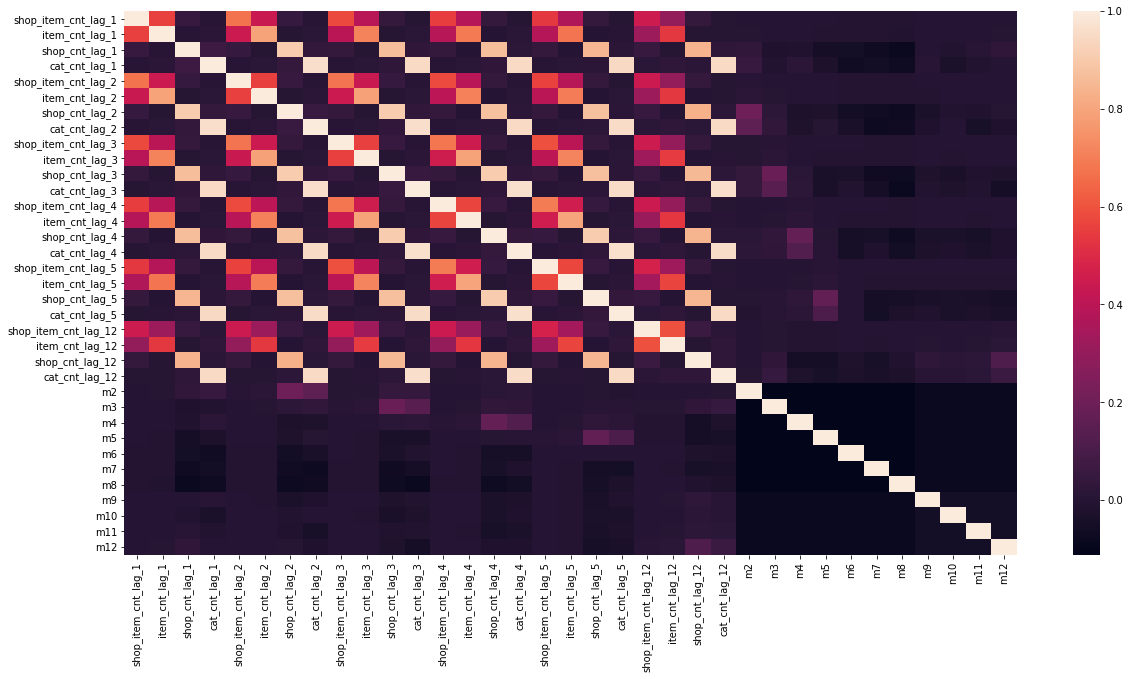

In [46]:
plt.figure(figsize=(20,10))
sns.heatmap(corr)

##### Linear Regression

In [20]:
lm = LinearRegression()

In [21]:
%%time
lm.fit(X_train,y_train)

Wall time: 1min 5s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [22]:
pred_lm = lm.predict(val[feats])

In [23]:
rmse_clip(y_true = val.loc[val.shop_item_cnt>0,'shop_item_cnt'],y_pred = pred_lm[val.shop_item_cnt>0])

18.161080853494752

In [51]:
gc.collect()

158

##### LGB

In [24]:
feats = ['shop_item_cnt_lag_1',  'item_cnt_lag_1',  'shop_cnt_lag_1', 'cat_cnt_lag_1',
         'shop_item_cnt_lag_2',  'item_cnt_lag_2',  'shop_cnt_lag_2', 'cat_cnt_lag_2',
         'shop_item_cnt_lag_3',  'item_cnt_lag_3',  'shop_cnt_lag_3', 'cat_cnt_lag_3',
         'shop_item_cnt_lag_4',  'item_cnt_lag_4',  'shop_cnt_lag_4', 'cat_cnt_lag_4',
         'shop_item_cnt_lag_5',  'item_cnt_lag_5',  'shop_cnt_lag_5', 'cat_cnt_lag_5',
         'shop_item_cnt_lag_12', 'item_cnt_lag_12', 'shop_cnt_lag_12','cat_cnt_lag_12',
         'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
         'shop_item_trd_1', 'shop_trd_1', 'item_trd_1', 'cat_trd_1'#,
#          'shop_item_trd_2', 'shop_trd_2', 'item_trd_2', 'cat_trd_2',
#          'shop_item_trd_3', 'shop_trd_3', 'item_trd_3', 'cat_trd_3'
        ]

In [25]:
%%time
monthly_sales_all = pd.read_hdf(r'../data2/monthly_sales_ex_fst_12m_w_lag_1hot_tr.h5','monthly_sales_all')

Wall time: 7.57 s


In [26]:
hold_out_df = monthly_sales_all.loc[monthly_sales_all.date_block_num == hold_out_month,
                            ['shop_id','item_id','shop_item_cnt']+feats]
val = monthly_sales_all.loc[monthly_sales_all.date_block_num == val_month,
                            ['shop_id','item_id','shop_item_cnt']+feats]
val[:3]

,shop_id,item_id,shop_item_cnt,shop_item_cnt_lag_1,item_cnt_lag_1,shop_cnt_lag_1,cat_cnt_lag_1,shop_item_cnt_lag_2,item_cnt_lag_2,shop_cnt_lag_2,...,m7,m8,m9,m10,m11,m12,shop_item_trd_1,shop_trd_1,item_trd_1,cat_trd_1
20,59,22154,0.0,0.0,6.0,1216.0,3436.0,0.0,8.0,998.0,...,0,0,1,0,0,0,1,0,0,0
42,59,2552,0.0,0.0,0.0,1216.0,286.0,0.0,0.0,998.0,...,0,0,1,0,0,0,1,0,1,1
64,59,2554,0.0,0.0,0.0,1216.0,286.0,0.0,0.0,998.0,...,0,0,1,0,0,0,1,0,1,1


In [27]:
X_train = monthly_sales_all.loc[monthly_sales_all.date_block_num<val_month,feats]
y_train = monthly_sales_all.loc[monthly_sales_all.date_block_num<val_month,'shop_item_cnt']

In [28]:
del monthly_sales_all
gc.collect()

710

In [29]:
%%time
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':4, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)

Wall time: 5min 32s


In [32]:
pred_lgb = model.predict(val[feats])
print("Val (32):",rmse_clip(y_true = val.loc[val.shop_item_cnt>0,'shop_item_cnt'],y_pred = pred_lgb[val.shop_item_cnt>0]))
print("Val (32):",rmse_clip(y_true = val.loc[(val.shop_item_cnt>0) & (val.shop_item_cnt<20),'shop_item_cnt'],y_pred = pred_lgb[(val.shop_item_cnt>0)&(val.shop_item_cnt<20)]))

Val (32): 17.992392137470283
Val (32): 1.770148685377452


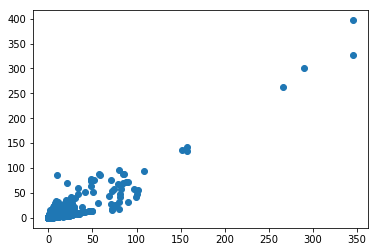

In [64]:
plt.scatter(pred_lgb[val.shop_item_cnt>0],pred_lm[val.shop_item_cnt>0])

([<matplotlib.axis.XTick at 0x1a8220169b0>,
 <a list of 34 Text xticklabel objects>)

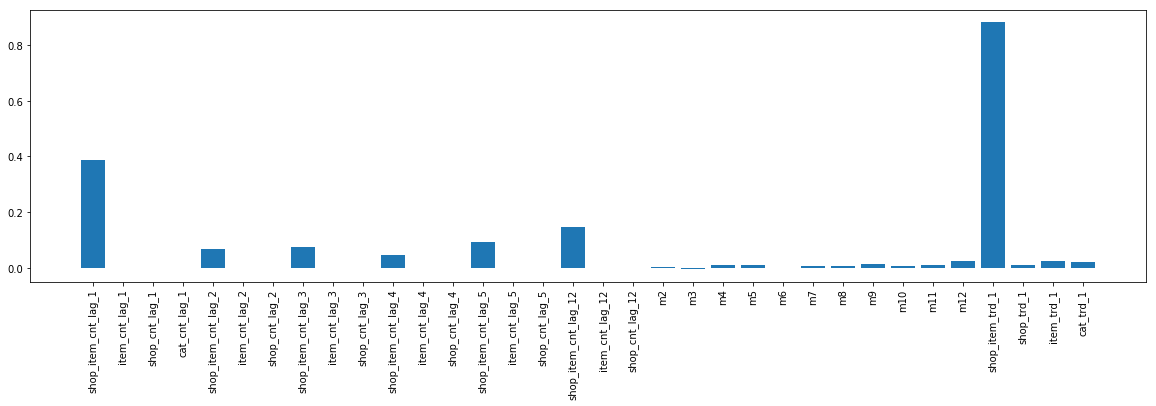

In [42]:
# This is not a good graph; features are not standardized, so the magnitude of coef is meaningless
plt.figure(figsize=(20,5))
ticks = list(range(len(lm.coef_)))
plt.bar(ticks,height=lm.coef_)
plt.xticks(ticks,feats,rotation=90)

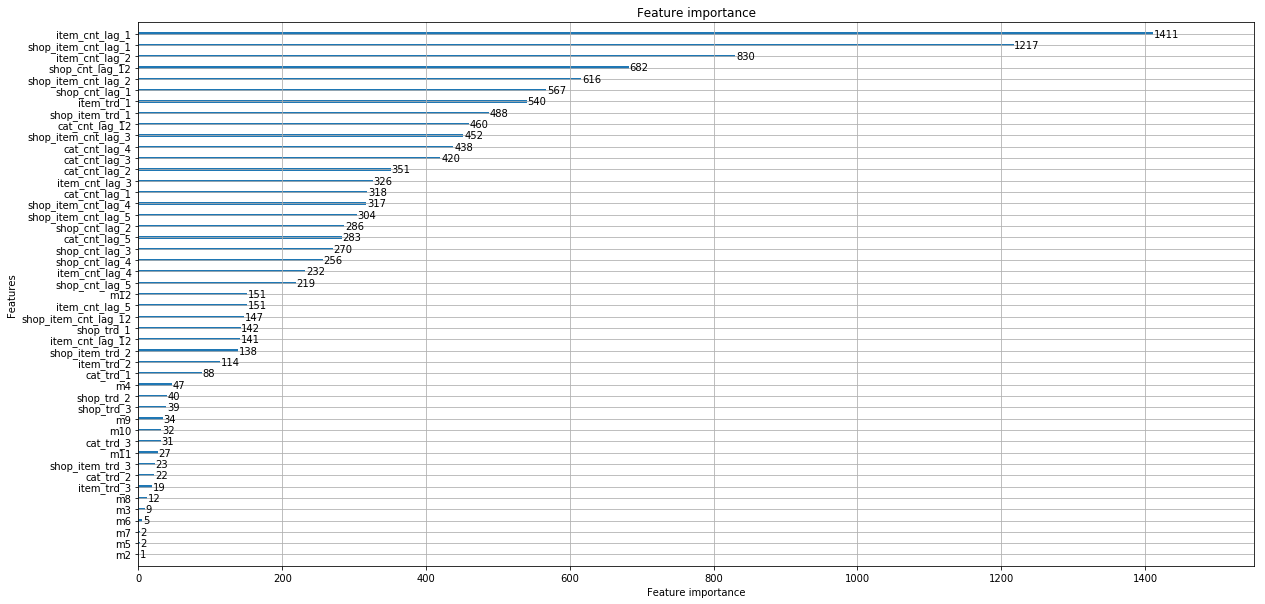

In [22]:
lgb.plot_importance(model,figsize=(20,10))

### Ok, why doesn't score improve???

In [66]:
val['lm_pred'] = pred_lm
val['lgb_pred'] = pred_lgb
val2 = val[val.shop_item_cnt>0]
val2.shape

(29652, 44)

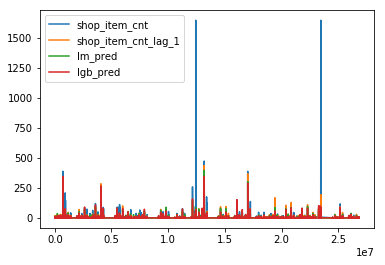

In [67]:
plt.figure(figsize=(20,5))
val2[['shop_item_cnt','shop_item_cnt_lag_1','lm_pred','lgb_pred']].plot()

## Ok there seems to be Extremely high sales of in month 32

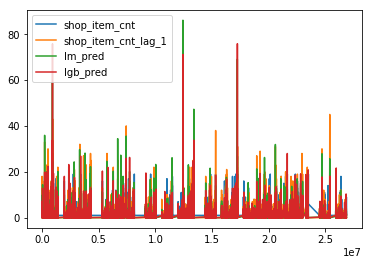

In [68]:
val2.loc[val2.shop_item_cnt<20,['shop_item_cnt','shop_item_cnt_lag_1','lm_pred','lgb_pred']].plot()

In [69]:
# Result below is for adding in 1 trend
for col in ['shop_item_cnt_lag_1','lm_pred','lgb_pred']:
    print(col,rmse_clip(val2.loc[val2.shop_item_cnt<20,'shop_item_cnt'],val2.loc[val2.shop_item_cnt<20,col]))

shop_item_cnt_lag_1 2.2048763591676313
lm_pred 2.0309601108176945
lgb_pred 1.770148685377452


<strong>Not too bad for the normal range... 

Stacking will work;

Since there is improvement, create a submission w only time-based features </strong>

### Create a new submission

In [61]:
%%time
monthly_sales_all = pd.read_hdf(r'../data2/monthly_sales_all_shop_item_w_lag.h5','monthly_sales_all')

Wall time: 7.16 s


In [62]:
monthly_sales_all = monthly_sales_all[(monthly_sales_all.date_block_num>=12) & (monthly_sales_all.date_block_num<34)]

In [64]:
monthly_sales_all = pd.merge(monthly_sales_all,m_onehot_df,how='left',on='month').drop(labels=['month'],axis=1)
monthly_sales_all[:3]

,cat_cnt,date_block_num,item_category_id,item_cnt,item_id,shop_cnt,shop_id,shop_item_cnt,cat_cnt_lag_1,item_cnt_lag_1,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,7545.0,12,37,0.0,22154,1500.0,59,0.0,9989.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,6044.0,13,37,0.0,22154,1428.0,59,0.0,7545.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,6334.0,14,37,0.0,22154,1475.0,59,0.0,6044.0,0.0,...,1,0,0,0,0,0,0,0,0,0


In [65]:
X_train = monthly_sales_all[feats]

In [66]:
y_train = monthly_sales_all['shop_item_cnt']

In [67]:
# del monthly_sales_all
gc.collect()

94

In [68]:
%%time
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)

Wall time: 8min


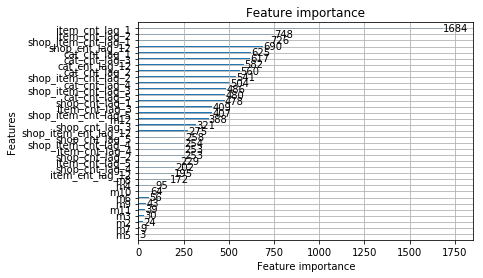

In [69]:
lgb.plot_importance(model)

#### Read in test data and get features

In [70]:
test = pd.read_csv(r'../data/test.csv.gz')
test[:3]

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


In [71]:
%%time
monthly_sales_all = pd.read_hdf(r'../data2/monthly_sales_all_shop_item_w_lag.h5','monthly_sales_all')

Wall time: 7.19 s


In [78]:
monthly_sales_all = monthly_sales_all[monthly_sales_all.date_block_num==34]

In [79]:
gc.collect()

1538

In [80]:
monthly_sales_all = pd.merge(monthly_sales_all,m_onehot_df,how='left',on='month')
monthly_sales_all[:3]

,cat_cnt,date_block_num,item_category_id,item_cnt,item_id,shop_cnt,shop_id,shop_item_cnt,cat_cnt_lag_1,item_cnt_lag_1,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,0.0,34,37,0.0,22154,0.0,59,0.0,4069.0,5.0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,34,58,0.0,2552,0.0,59,0.0,452.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,0.0,34,58,0.0,2554,0.0,59,0.0,452.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [82]:
test2 = pd.merge(test,monthly_sales_all,on=['shop_id','item_id'],how='left').fillna(0)
test2.loc[:,'m11'] = 1
print(test2.shape)
test2[:3]

(214200, 45)


,ID,shop_id,item_id,cat_cnt,date_block_num,item_category_id,item_cnt,shop_cnt,shop_item_cnt,cat_cnt_lag_1,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,0,5,5037,0.0,34.0,19.0,0.0,0.0,0.0,2450.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
2,2,5,5233,0.0,34.0,19.0,0.0,0.0,0.0,2450.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0


In [92]:
test2['item_cnt_month'] = model.predict(test2[feats]).clip(0,20)

In [93]:
test2[['ID','item_cnt_month']].to_csv(r'../output/10_1015_lgb_time_feats.csv',index=False)